# Homework 1
### ASTROINFORMATICS FALL 2018
https://github.com/astromundus/astroinfo2018


## Problem 1

Using astroML figure 3.12 as a template, see

http://www.astroml.org/book_figures/chapter3/fig_cauchy_median_mean.html

add another panel, similar to the top panel, that will plot and compare 
results for standard deviation and $\sigma_G$. 


## Problem 2

Generate a sample of 10,000 data values drawn from N($\mu$=1.0, $\sigma$=0.2) and
draw a pretty histogram, with the bin size determined using the Freedman-Diaconis
rule. Show (Poissonian) uncertainty for each histogram value, and overplot the
true distribution. 

## Problem 3

Do the same for a Cauchy distribution with the same $\mu$ and $\gamma=0.2$. 

## Problem 4
Repeat the problem 2, but now add to the Gaussian sample (concatenate arrays) 
another sample of 10,000 data values drawn from a Cauchy distribution with
$\mu=2.0$ and $\gamma=0.5$. Do it twice: once with the bin size determined 
using the Freedman-Diaconis rule and once using the Scott's rule. Discuss the difference.  

<br>
# Solutions

### Some useful definitions and functions

In [11]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

This astroML function adjusts matplotlib settings for a uniform feel in the 
textbook. Note that with `usetex=True`, fonts are rendered with $\LaTeX$. This 
may result in an error if $\LaTeX$ is not installed on your system.  In that 
case, you can set usetex to `False`.

In [12]:
import astroML
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

## Problem 1

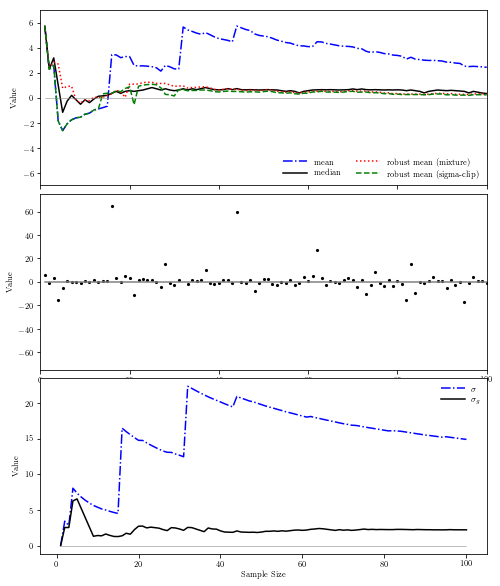

In [13]:
from scipy import optimize
from scipy.stats import cauchy, norm
from scipy import stats

from astropy.stats.histogram import freedman_bin_width
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


def robust_mean_mixture(x):
    """Compute the mean via a mixture of two Gaussians

    One Gaussian accounts for outliers, and one Gaussian accounts  for
    the true distribution.  This cannot be computed analytically, so
    it uses scipy's function optimization
    """
    if len(x) == 1:
        return x

    x = x.ravel()

    mu_bg = np.mean(x)
    sig_bg = 3 * np.std(x)

    likelihood = lambda v: -np.sum(np.log(norm.pdf(x, v[0], v[1])
                                          + norm.pdf(x, mu_bg, sig_bg)))

    v0 = np.array([0, 30])

    v_best = optimize.fmin(likelihood, v0, disp=False)

    return v_best[0]


def robust_mean_iterated(x, sigma_cut=3):
    """Compute the robust mean iteratively

    After computing the mean, points further than 3 sigma from the mean
    are removed and the result is repeated until convergence.
    """
    flag = np.ones(x.shape, dtype=bool)
    n_to_keep = x.size

    while True:
        xf = x[flag]
        mu = xf.mean()
        sig = xf.std()
        if len(xf) == 1:
            break

        x_sig = abs((x - mu) / sig)

        too_far = (x_sig > sigma_cut)
        flag[too_far] = False
        n_flag = flag.sum()

        if n_flag == n_to_keep:
            break
        else:
            n_to_keep = n_flag

    return mu

#------------------------------------------------------------
# Create the distribution and compute means and medians
np.random.seed(6)
mu = 0
gamma = 2

xi = cauchy(mu, gamma).rvs(100)
Nrange = np.arange(1, len(xi) + 1)

mean = [np.mean(xi[:N]) for N in Nrange]
median = [np.median(xi[:N]) for N in Nrange]
mean_mixture = [robust_mean_mixture(xi[:N]) for N in Nrange]
mean_iter = [robust_mean_iterated(xi[:N]) for N in Nrange]

std = [np.std(xi[:N]) for N in Nrange] #find standard deviation of the cauchy distribution
stdg=[0.7413*np.percentile(xi[:N], 75)-0.7413*np.percentile(xi[:N], 25) for N in Nrange]

#------------------------------------------------------------
# Plot the results as a function of number of points
fig = plt.figure(figsize=(8,10))
fig.subplots_adjust(hspace=0.05)

# first plot the mean
ax = fig.add_subplot(311)
ax.plot(Nrange, mean, '-.b', label='mean')
ax.plot(Nrange, median, '-k', label='median')
ax.plot(Nrange, mean_mixture, ':r', label='robust mean (mixture)')
ax.plot(Nrange, mean_iter, '--g', label='robust mean (sigma-clip)')
ax.plot(Nrange, 0 * Nrange, '-', c='gray', lw=0.5)

ax.set_xlim(0, 100)
ax.set_ylim(-7, 7)
ax.legend(loc=4, ncol=2, frameon=False)
ax.set_ylabel('Value')
ax.xaxis.set_major_formatter(plt.NullFormatter())

# now plot the median
ax = fig.add_subplot(312)
ax.scatter(Nrange, xi, lw=0, s=10, c='k')
ax.plot(Nrange, 0 * Nrange, '-', c='gray')
ax.set_xlim(0, 100)
ax.set_ylim(-75, 75)
ax.set_xlabel('Sample Size')
ax.set_ylabel('Value')

ax = fig.add_subplot(313)
ax.plot(Nrange, std, '-.b', label='$\sigma$')
ax.plot(Nrange, stdg, '-k', label='$\sigma_g$')
ax.set_xlabel('Sample Size')
ax.set_ylabel('Value')
ax.plot(Nrange, 0 * Nrange, '-', c='gray', lw=0.5)
plt.legend(frameon=False)
plt.show()

## Problem 2

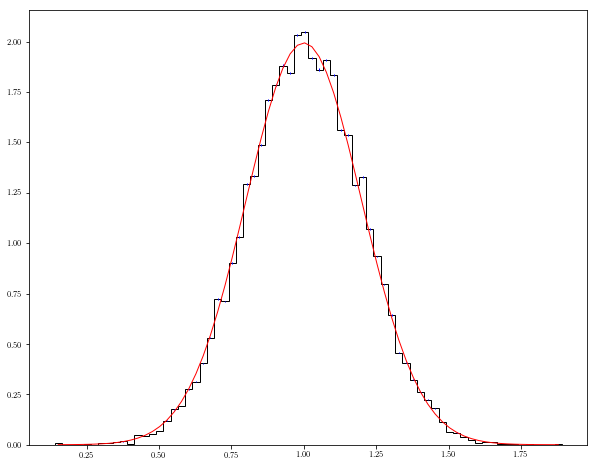

In [14]:
mu1 = 1 #define mean value
sigma1 = 0.2 #define standard deviation
xi1 = np.random.normal(mu1, sigma1,10000)
Nrange1 = np.arange(1, len(xi1) + 1)
width1,bins1=astroML.density_estimation.freedman_bin_width(xi1,return_bins=True) #define bin width and bins according to the Freedman-Diaconis rule
fig1,ax1=plt.subplots(figsize=(10,8))
y1,edges1,patches=plt.hist(xi1,bins=bins1,normed=True,histtype='step',color='black',linewidth=1.0,label='histogram') #plot histogram and define values of
#histogram bins, edges of bins and patches
error1 = np.sqrt(y1)/(10000*width1) #find values of normalized errors
bincenters1 = 0.5*(edges1[1:]+edges1[:-1]) #define bin centers to plot error bars (uncertainties) at the bin centers
ax1.errorbar(bincenters1,y1,yerr=error1,linestyle='None',fmt='b',linewidth=1.0) #plot Poissonian uncertainties
z1_t = norm.pdf(bincenters1, mu1, sigma1) #define pdf for normal distribution
ax1.plot(bincenters1,z1_t,c='r',linewidth=1.0,label='expected distribution') #plot expected distribution (pdf)

To plot expected (true) distribution together with histogram on the one subplot we need to have normalized histogram. But, if we are plotting normalied histogram together with poissonian uncertainties for each bin, we need to have normalized uncertainties too as it was done upper. However, as we can see, normalized uncertainties are almost invisible on the plot. To see them we can draw not normalized histogram and add not normalized uncertainties to the plot, but in this case we are unable to overplot pdf.

<Container object of 3 artists>

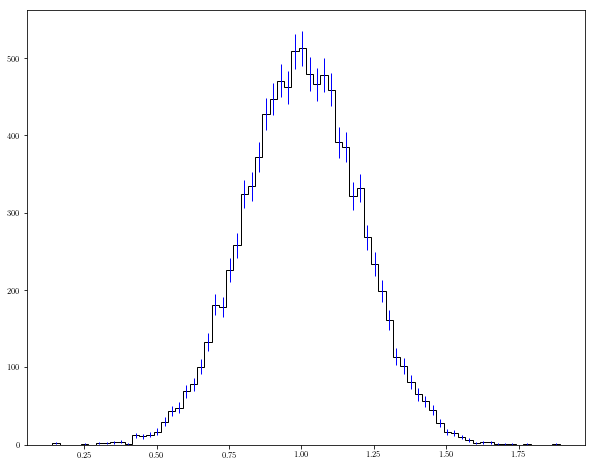

In [15]:
fig1,ax1=plt.subplots(figsize=(10,8))
y1,edges1,patches=plt.hist(xi1,bins=bins1,histtype='step',color='black',linewidth=1.0) #plot histogram and define values of
#histogram bins, edges of bins and patches
error1 = np.sqrt(y1) #find values of normalized errors
bincenters1 = 0.5*(edges1[1:]+edges1[:-1]) #define bin centers to plot error bars (uncertainties) at the bin centers
ax1.errorbar(bincenters1,y1,yerr=error1,linestyle='None',fmt='b',linewidth=1.0) #plot Poissonian uncertainties

## Problem 3

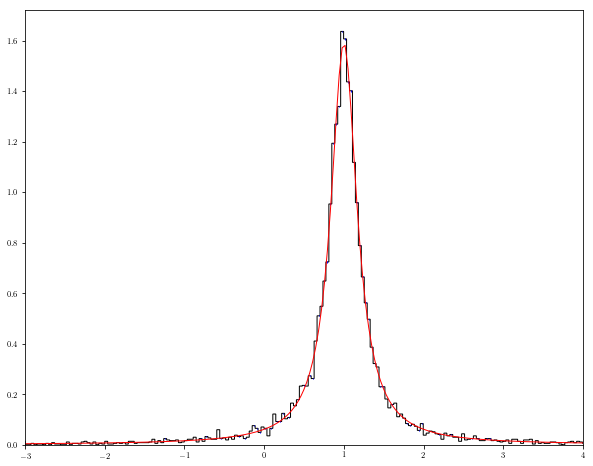

In [16]:
mu2 = 1 #define mean value
gamma2 = 0.2 #define standard deviation
xi2 = cauchy(mu2, gamma2).rvs(10000)
Nrange2 = np.arange(1, len(xi2) + 1)
width2,bins2=astroML.density_estimation.freedman_bin_width(xi2,return_bins=True) #define bin width and bins according to the Freedman-Diaconis rule
fig2,ax2=plt.subplots(figsize=(10,8))
plt.xlim(-3, 4) #set x-axis limit to see histogram
y2,edges2,patches2=plt.hist(xi2,bins=bins2,histtype='step',normed=True, color='black',linewidth=1.0,label='histogram') #plot histogram and define values of
#histogram bins, edges of bins and patches
error2 = np.sqrt(y2)/(10000*width2) #find values of normalized errors
bincenters2 = 0.5*(edges2[1:]+edges2[:-1]) #define bin centers to plot error bars (uncertainties) at the bin centers
ax2.errorbar(bincenters2,y2,yerr=error2,linestyle='None',fmt='b',linewidth=1.0,label='expected distribution') #plot Poissonian uncertainties
z2_t = cauchy.pdf(bincenters2, mu2, gamma2) #define pdf for cauchy distribution
ax2.plot(bincenters2,z2_t,c='r',linewidth=1.0) #plot expected distribution (pdf)

To plot expected (true) distribution together with histogram on the one subplot we need to have normalized histogram. But, if we are plotting normalied histogram together with poissonian uncertainties for each bin, we need to have normalized uncertainties too as it was done upper. However, as we can see, normalized uncertainties are almost invisible on the plot. To see them we can draw not normalized histogram and add not normalized uncertainties to the plot, but in this case we are unable to overplot pdf.

<Container object of 3 artists>

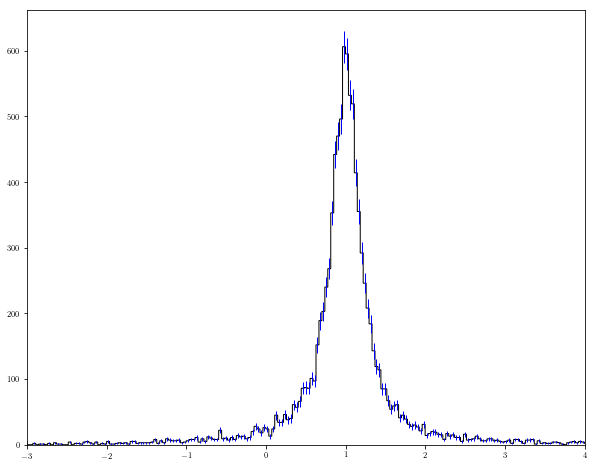

In [17]:
fig2,ax2=plt.subplots(figsize=(10,8))
plt.xlim(-3, 4) #set x-axis limit to see histogram
y2,edges2,patches2=plt.hist(xi2,bins=bins2,histtype='step',color='black',linewidth=1.0) #plot histogram and define values of
#histogram bins, edges of bins and patches
error2 = np.sqrt(y2) #find values of normalized errors
bincenters2 = 0.5*(edges2[1:]+edges2[:-1]) #define bin centers to plot error bars (uncertainties) at the bin centers
ax2.errorbar(bincenters2,y2,yerr=error2,linestyle='None',fmt='b',linewidth=1.0) #plot Poissonian uncertainties

## Problem 4

Below histogram is calculated and plotted using bins estimated via Freedman-Diaconis rule. All steps are explained in the upper parts.

<Container object of 3 artists>

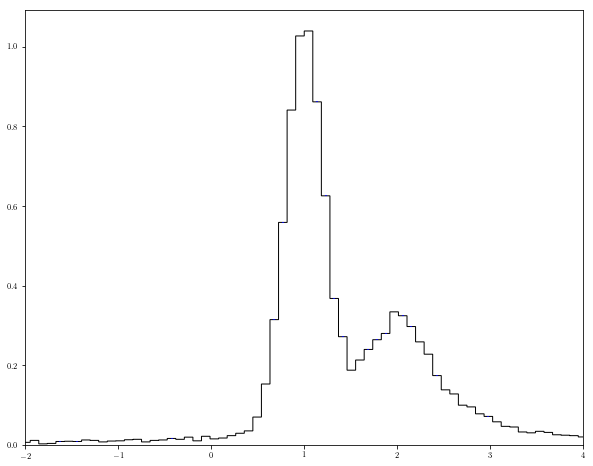

In [18]:
mu3=2.0
gamma3=0.5
xi3=cauchy(mu3, gamma3).rvs(10000)
xi4=np.concatenate((xi1,xi3))
width3,bins3=astroML.density_estimation.freedman_bin_width(xi3,return_bins=True)
fig3,ax3=plt.subplots(figsize=(10,8))
plt.xlim(-2, 4)
y3,edges3,patches3=plt.hist(xi4,bins=bins3,normed=True,histtype='step',color='black',linewidth=1.0)
error3 = np.sqrt(y3)/(10000*width3)
bincenters3 = 0.5*(edges3[1:]+edges3[:-1])
ax3.errorbar(bincenters3,y3,yerr=error3,linestyle='None',fmt='b') 

Below histogram is calculated and plotted using bins estimated via Scott's rule. All steps are explained in the upper parts.

<Container object of 3 artists>

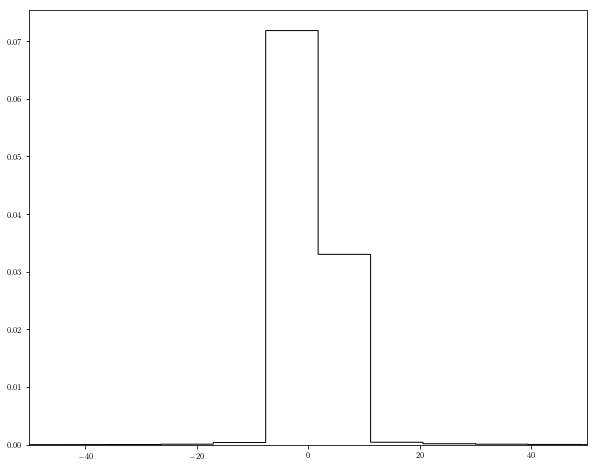

In [19]:
mu3=2.0
gamma3=0.5
width4,bins4=astroML.density_estimation.scotts_bin_width(xi4,return_bins=True)
fig4,ax4=plt.subplots(figsize=(10,8))
plt.xlim(-50, 50)
y4,edges4,patches4=plt.hist(xi4,bins=bins4,normed=True,histtype='step',color='black',linewidth=1.0)
error4 = np.sqrt(y4)/(10000*width4)
bincenters4 = 0.5*(edges4[1:]+edges4[:-1])
ax4.errorbar(bincenters4,y4,yerr=error4,linestyle='None',fmt='r')

Plot of two histograms with bins estimated by different methods to compare them.

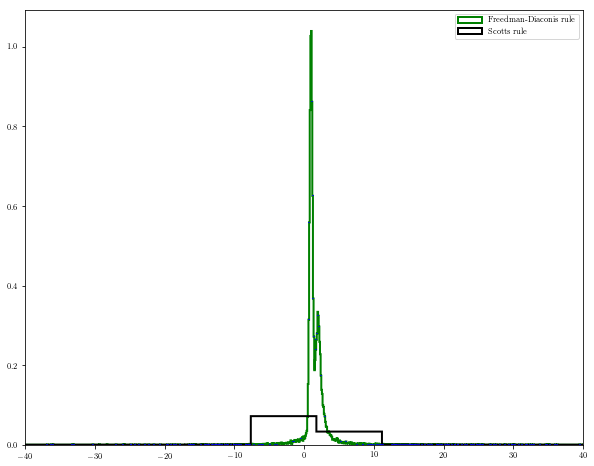

In [20]:
fig5,ax5=plt.subplots(figsize=(10,8))
plt.xlim(-40, 40)
y3,edges3,patches3=plt.hist(xi4,bins=bins3,normed=True,histtype='step',color='green',linewidth=2.0,label='Freedman-Diaconis rule')
error3 = np.sqrt(y3)/(10000*width3)
bincenters3 = 0.5*(edges3[1:]+edges3[:-1])
ax5.errorbar(bincenters3,y3,yerr=error3,linestyle='None',fmt='b') 
y4,edges4,patches4=plt.hist(xi4,bins=bins4,normed=True,histtype='step',color='black',linewidth=2.0,label='Scotts rule')
error4 = np.sqrt(y4)/(10000*width4)
bincenters4 = 0.5*(edges4[1:]+edges4[:-1])
ax5.errorbar(bincenters4,y4,yerr=error4,linestyle='None',fmt='r') 
plt.legend()

### Difference between the Freedman-Diaconis rule and the Scott's rule

The main visible difference in the bin size determination between the Freedman-Diaconis rule and the Scott's rule is that using the Scott's rule we have less number of bins and bigger bin width while the Freedman-Diaconis rule gives us more bins and less bin width. It is also should be noted that our data sample consists of two different distributions (normal/Gaussian distribution and Cauchy distribution). And as we can see, histogram plotted with the Freedman-Diaconis rule clearly shows the presence of this two different distrbutions, one with the mean value at 1 (Gaussian) and second with the mean value at 2 (Cauchy). At the same time Scott's rule distinguish the presence of two different distribution less clearly because according to how Scott's rule is defined, it assumes that underlying distribution is Gaussian distribution. Because of that using the histogram with bins defined by the Scott's rule we are not able to say that we have two different distributions in data and the bins are defined in that way which we see on the plot. In comparison with Scott's rule, the algorithm of Freedman-Diaconis rule doesn't assume that the given distribution is Gaussian, so the partition into bins by this method, although it tries to adjust the distribution to one, but does not try to unify it in the form of a Gaussian. Therefore, because we have a situation when given data points come not from the unique distribution but from two distributions one of which is Gaussian and second is Cauchy that defined by different distribution parametrs we can see on the upper plots. The difference in bin widths defined by the Freedman-Diaconis rule and the Scott's rule also has origin in the definitions of these two rules (and this difference would be present even if we had a single Gaussian distribution).